# Plant Disease Detection - Deep Learning Project

## Initial Setup

In [1]:
# Imports
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import shutil
import random
import importlib
import pandas as pd
import albumentations as A
import numpy as np

from tqdm.auto import tqdm
from torch import nn
from torchvision import transforms
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from typing import Dict, List
from albumentations.pytorch import ToTensorV2

import helpers

In [2]:
import helpers.setup
importlib.reload(helpers.setup)
from helpers.setup import set_device, set_seeds, set_pandas_options, reset_pandas_options

# Set the device
device = set_device()

# Set random seeds
set_seeds(seed=42, device=device)

# Pandas display setup to avoid truncation
set_pandas_options()
reset_pandas_options()

## Data Acquisition

In [3]:
import helpers.acquisition
importlib.reload(helpers.acquisition)
from helpers.acquisition import create_dataset

url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded"
data_dir = "data"
zip_path = os.path.join(data_dir, "data_compressed.zip")
extracted_dir = "Plant_leave_diseases_dataset_without_augmentation"
splits = {
    'data_10_10_80': [0.1, 0.1, 0.8], #train 10% test 10% holdout 80%
    'data_20_10_70': [0.2, 0.1, 0.7],
    'data_30_10_60': [0.3, 0.1, 0.6],
    'data_70_20_10': [0.7, 0.2, 0.1]
}

create_dataset(url, zip_path, splits, data_dir, extracted_dir)

Data folder already exists. Skipping download...
Nothing to extract. Skipping...
Directory data_10_10_80 already exists. Skipping ...
Directory data_20_10_70 already exists. Skipping ...
Directory data_30_10_60 already exists. Skipping ...
Directory data_70_20_10 already exists. Skipping ...
Dataset splits generated successfully!


## Data Exploration

In [4]:
import helpers.exploration
importlib.reload(helpers.exploration)
from helpers.exploration import traverse_dirs

data_dir_names = list(splits.keys())
classes_df = traverse_dirs(data_dir_names)
classes_df = classes_df.groupby(["dataset", "split_type", "class"]).sum()
classes_df

image_count
dataset       split_type class                                                     
data_10_10_80 holdout    Apple___Apple_scab                                     504
                         Apple___Black_rot                                      497
                         Apple___Cedar_apple_rust                               221
                         Apple___healthy                                       1317
                         Background_without_leaves                              915
...                                                                             ...
data_70_20_10 train      Tomato___Spider_mites Two-spotted_spider_mite         1173
                         Tomato___Target_Spot                                   982
                         Tomato___Tomato_Yellow_Leaf_Curl_Virus                3749
                         Tomato___Tomato_mosaic_virus                           261
                         Tomato___healthy                                      1113

[468 rows x 1 columns]

## Data Preparation and Augmentation

### Create Datasets and Dataloaders

In [ ]:
import helpers.preparation
importlib.reload(helpers.preparation)
from helpers.preparation import create_dataloaders, display_img_grid, display_img_sample

import albumentations as A
from albumentations.pytorch import ToTensorV2

test_transform = A.Compose([
    A.Resize(264, 264),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataloader_10_10_80_aug, test_dataloader_10_10_80 = create_dataloaders("data_10_10_80/train", 
                                                                         "data_10_10_80/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_10_10_80_cut, test_dataloader_10_10_80 = create_dataloaders("data_10_10_80/train", 
                                                                         "data_10_10_80/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_10_10_80, test_dataloader_10_10_80 = create_dataloaders("data_10_10_80/train", 
                                                                         "data_10_10_80/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

train_dataloader_20_10_70_aug, test_dataloader_20_10_70 = create_dataloaders("data_20_10_70/train", 
                                                                         "data_20_10_70/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_20_10_70_cut, test_dataloader_20_10_70 = create_dataloaders("data_20_10_70/train", 
                                                                         "data_20_10_70/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_20_10_70, test_dataloader_20_10_70 = create_dataloaders("data_20_10_70/train", 
                                                                         "data_20_10_70/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

train_dataloader_30_10_60_aug, test_dataloader_30_10_60 = create_dataloaders("data_30_10_60/train", 
                                                                         "data_30_10_60/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_30_10_60_cut, test_dataloader_30_10_60 = create_dataloaders("data_30_10_60/train", 
                                                                         "data_30_10_60/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_30_10_60, test_dataloader_30_10_60 = create_dataloaders("data_30_10_60/train", 
                                                                         "data_30_10_60/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

train_dataloader_70_20_10_aug, test_dataloader_70_20_10 = create_dataloaders("data_70_20_10/train", 
                                                                         "data_70_20_10/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_70_20_10_cut, test_dataloader_70_20_10 = create_dataloaders("data_70_20_10/train", 
                                                                         "data_70_20_10/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_70_20_10, test_dataloader_70_20_10 = create_dataloaders("data_70_20_10/train", 
                                                                         "data_70_20_10/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

len(train_dataloader_10_10_80_aug), len(train_dataloader_10_10_80), len(test_dataloader_10_10_80)

len(train_dataloader_20_10_70_aug), len(train_dataloader_20_10_70), len(test_dataloader_20_10_70)

len(train_dataloader_30_10_60_aug), len(train_dataloader_30_10_60), len(test_dataloader_30_10_60)

len(train_dataloader_70_20_10_aug), len(train_dataloader_70_20_10), len(test_dataloader_70_20_10)

### Display Sample Batches and Images

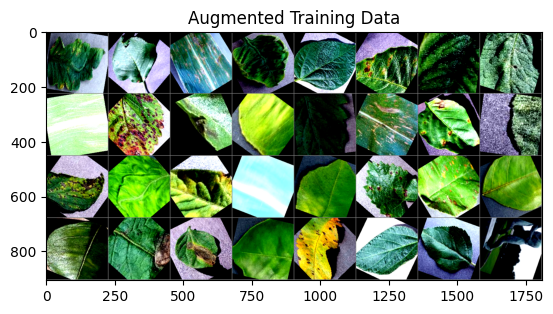

Tomato___Bacterial_spot
Apple___Black_rot
Corn___Cercospora_leaf_spot Gray_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Soybean___healthy
Pepper,_bell___Bacterial_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Target_Spot
Corn___healthy
Strawberry___Leaf_scorch
Apple___Apple_scab
Orange___Haunglongbing_(Citrus_greening)
Tomato___Bacterial_spot
Corn___Cercospora_leaf_spot Gray_leaf_spot
Pepper,_bell___Bacterial_spot
Tomato___healthy
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Leaf_Mold
Corn___healthy
Orange___Haunglongbing_(Citrus_greening)
Grape___Black_rot
Apple___Cedar_apple_rust
Orange___Haunglongbing_(Citrus_greening)
Orange___Haunglongbing_(Citrus_greening)
Potato___Late_blight
Tomato___Early_blight
Orange___Haunglongbing_(Citrus_greening)
Peach___Bacterial_spot
Soybean___healthy
Apple___healthy
Background_without_leaves


In [16]:
display_img_grid(train_dataloader_10_10_80_aug, "Augmented Training Data")

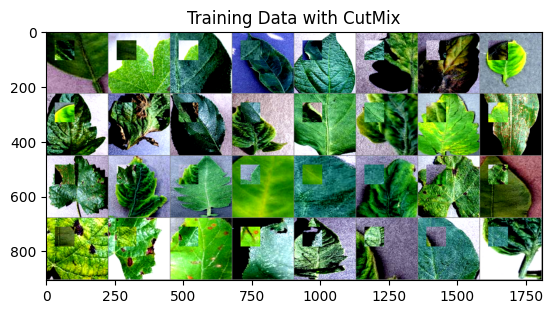

Orange___Haunglongbing_(Citrus_greening)
Squash___Powdery_mildew
Soybean___healthy
Apple___Apple_scab
Soybean___healthy
Tomato___Leaf_Mold
Tomato___Late_blight
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Late_blight
Apple___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Pepper,_bell___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Corn___Common_rust
Grape___Black_rot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___healthy
Orange___Haunglongbing_(Citrus_greening)
Soybean___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Orange___Haunglongbing_(Citrus_greening)
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___Black_rot
Apple___Cedar_apple_rust
Apple___Black_rot
Tomato___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Soybean___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [17]:
display_img_grid(train_dataloader_10_10_80_cut, "Training Data with CutMix", is_cutmix=True)

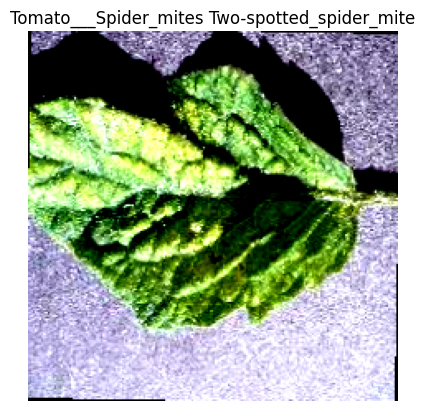

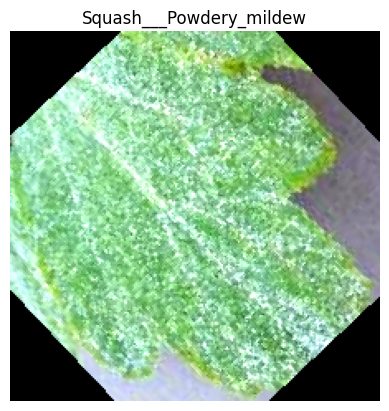

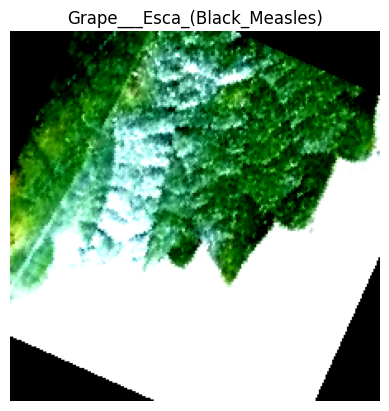

In [18]:
display_img_sample(train_dataloader_10_10_80_aug, "Sample Augmented Data with Labels", sample_size=3)

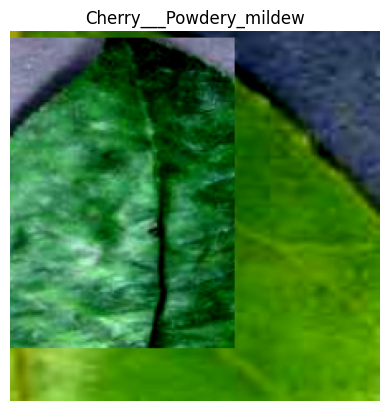

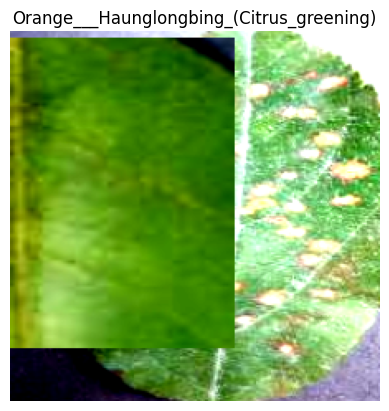

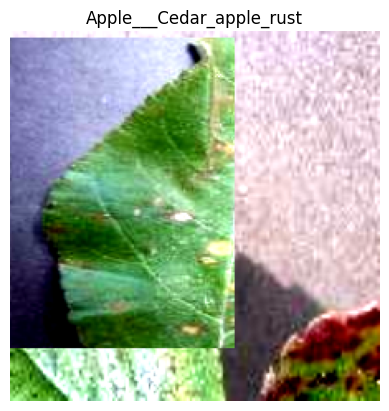

In [19]:
display_img_sample(train_dataloader_10_10_80_cut, "Sample Cutmix Data with Labels", is_cutmix=True, sample_size=3)

## Data Augmentation with GAN

In [ ]:
# GAN and NoGAN

# Data Augmentation

# Different data splits 
    # 10% train 10% test 80% holdout (GAN and NoGAN)
    # 20% train 10% test 70% holdout (GAN and NoGAN)
    # 30% train 10% test 60% holdout (GAN and NoGAN)
    # 70% train 20% test 10% holdout (GAN and NoGAN) - To be used only after experiment tracking

## Modeling

### Getting Pre-trained Models

In [22]:
import helpers.modeling
importlib.reload(helpers.modeling)
from helpers.modeling import create_effnetb0, create_vit

# EfficientNetB0 - as the highest performing overall in Hassan et al. 99.56%
effnetb0_model = create_effnetb0(device, out_features=39)

# ViT - example of transformer based approach
vit_model = create_vit(device, out_features=39)

EffNetB0 model created successfully.
ViT model created successfully.


### Summary of Pre-trained Model 

In [23]:
summary(model=effnetb0_model,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 39]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [24]:
summary(model=vit_model,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 39]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Getting Pre-trained Models
    # EfficientNetB0 - as the highest performing overall in Hassan et al. 99.56%
    # ViT - transformer based approach

# Create the architecture for my own model
    # Combine EfficientNetB0 with Attention blocks like in Thakur et al. (2022)

## Model Training and Experiment Tracking

In [ ]:
# Setup Summary Writer

# Train Model while recording experiment run and saving models
    # different epochs, learning rates and dropout rates

# Display tensorboard and select highest performing model to train further

    #### MAYBE EXPLORE ML FLOW if time allows

## Model Selection and Improvement

In [ ]:
# Load the most promising model 

# Train it on 70% train 20% test 10% holdout (either GAN or no GAN depending on which performed better)

# Calculate accuracy, precision, recall for the model (+ confusion matrix?)

# Save the model

## Make Predictions

In [ ]:
# Predict on test set and display

# Predict on holdout set and display

## Model Deployment

In [20]:
# Deploy the model using Gradio

# THE END